# BlenderSpike demo

## Simple action potential

In [1]:
from neuron import h
from neuron.units import um, mV
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import sys
sys.path.append("../../")
import blenderspike_py


from importlib import reload
reload(blenderspike_py)
import pickle

h.load_file("stdrun.hoc")

1.0

## Creating a NEURON simple model

### Model definition

In [2]:
biophysics_parameters={
    "Rm": 500, #specific membrane resistivity in ohm-cm^2 (leak channels)
    "Cm":1,  #specific membrane capacitance in uF/cm^2 
    "Ra":300,  #internal resistivity in ohm-cm
}

class BallandStick():

    def __init__(self, gid=0):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()


    def _setup_morphology(self):
        self.soma = h.Section(name="soma", cell=self)


        self.axon = h.Section(name="axon", cell=self)
        self.axon.nseg=25
        self.axon.connect(self.soma(0.5))

        self.all = self.soma.wholetree()

        self.soma.L = self.soma.diam = 12.6157 * um
        self.axon.L = 200 * um
        self.axon.diam = 1 * um

        h.define_shape()
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = biophysics_parameters["Ra"]  # Axial resistance in Ohm * cm 
            sec.cm = biophysics_parameters["Cm"]   # Membrane capacitance in micro Farads / cm^2
            sec.insert(h.hh)
            sec.insert(h.pas)
            sec.g_pas = 1/biophysics_parameters["Rm"]

    def __repr__(self):
        return "BallandStick[{}]".format(self._gid)

### Instantiating and running the model

In [3]:
cell = BallandStick(0)
cell_recorder = blenderspike_py.CellRecorder(cell.all) # Initialising CellRecorder class to continuously record the voltage from all sections
t = h.Vector().record(h._ref_t)
stim = h.IClamp(cell.soma(0.5))
stim.dur = 2
stim.amp = 0.2
stim.delay = 1

h.dt = 0.005
h.finitialize(-70*mV)
h.continuerun(10)

0.0

## Let's look at the results

Voltage arrays are saved in cell_recorder.monitors, which is a list of `SectionMonitor` instances, each recording voltage from one Section

Note that `len(cell_recorder.monitors) == len(cell.all)`

In [4]:
cell_recorder.monitors

Inside each `SectionMonitor` there is a list of `h.Vector` objects (accessed by `SectionMonitor.Vectors`)

Each `Vector` can be cast to a numpy array to obtain the voltage trace for the specified segment

Text(0.5, 1.0, 'Axon voltage')

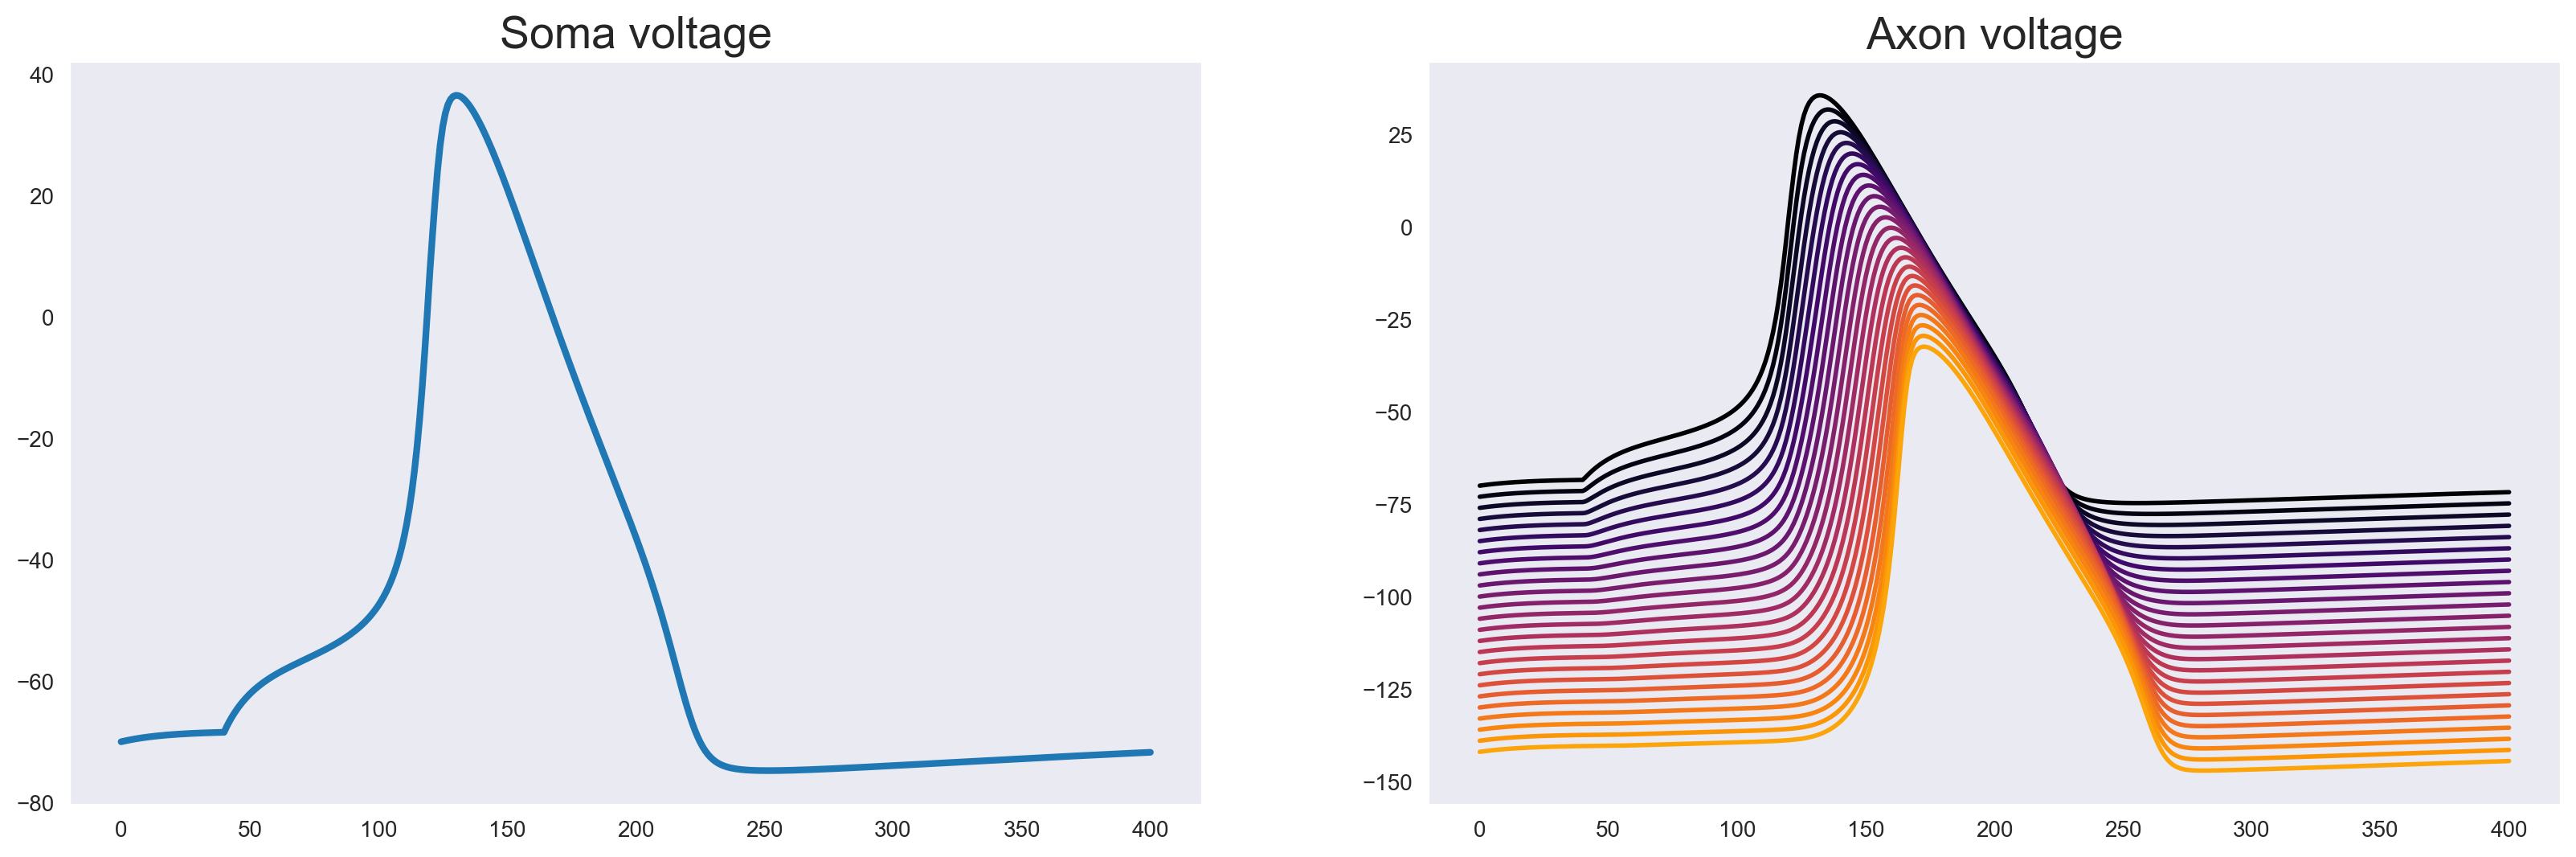

In [6]:
sns.set_style("dark")
fig, axs = plt.subplots(1,2,figsize=(20,6),dpi=200)

# Soma
axs[0].plot(cell_recorder.monitors[0].Vectors[0],lw=3) # Voltage from soma (section #0) and its one and only segment (Vectors[0])
axs[0].set_title("Soma voltage", fontsize=20)

# Axon
for k,vec in enumerate(cell_recorder.monitors[1].Vectors):
    axs[1].plot(vec-3*k, color=plt.cm.inferno(k/30),lw=2) # Voltage from axon (section #1) and all of its segments (k)
axs[1].set_title("Axon voltage", fontsize=20)

## Brining the model to Blender

- `FRAME_NUM` – number of frames on Blender timeline our animation should occupy (interpolation will be performed)

In [7]:
cell_recorder.save_pickle(filename="Simple AP.pickle", 
                            FRAME_NUM=300)

<img src="../../assets/Blender interface - simple AP.png">

## Resulting animation ✨

<img src="../../assets/demo animations/Simple AP.gif">